# Sub-daily data

Here we fit NeuralProphet to data with 5-minute resolution (daily temperatures at Yosemite). 

Based on our first contact with the data, we set:
* First, we disable `weekly_seasonality`, as nature does not follow the human week's calendar.
* Second, we increase `n_changepoints`, and increase `changepoints_range`, as we are doing short-term predictions.

In [1]:
import pandas as pd
from neuralprophet import NeuralProphet
df = pd.read_csv('../example_data/yosemite_temps.csv')

In [2]:
m = NeuralProphet(
    changepoints_range=0.95,
    n_changepoints=30,
    weekly_seasonality=False,
)
metrics = m.fit(df, freq='5min')

INFO: nprophet - _handle_missing_data: 12 NaN values in column y were auto-imputed.
INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 6


INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 5.34E-01
Epoch[6/6]: 100%|██████████| 6/6 [00:01<00:00,  3.34it/s, SmoothL1Loss=0.00291, MAE=3.34, RegLoss=0]


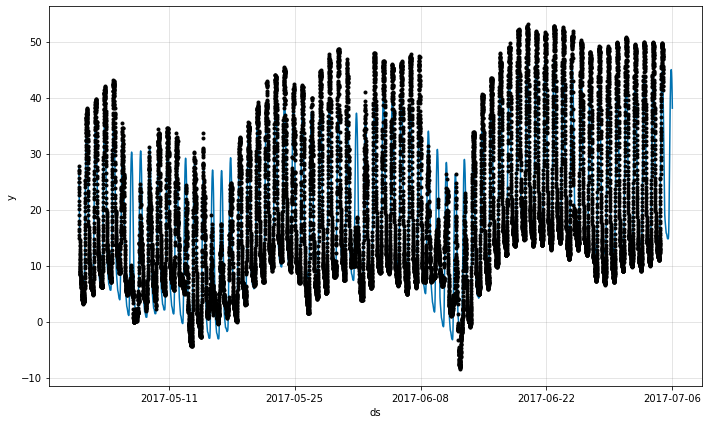

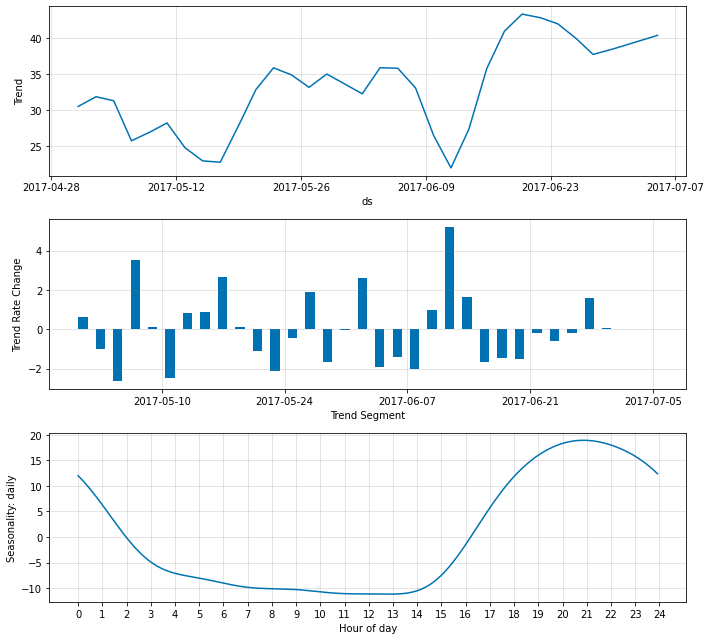

In [3]:
future = m.make_future_dataframe(df, periods=1*288, n_historic_predictions=True)
forecast = m.predict(future)
fig = m.plot(forecast)
# fig_comp = m.plot_components(forecast)
fig_param = m.plot_parameters()

## Next-step forecast with autoregression
Further, we can make use of the fact that tomorrow's weather is most likely similar to yesterdays weather.
This means that we will regress our time series on it's most recent past values, also known as autoregression.

We can achieve this by setting `n_lags` to the desired number of past observations to regress over. This value is also known as the 'AR order'. 

Here, we predict the temperature in the next 5 minutes based on the last hour:

In [4]:
m = NeuralProphet(
    n_lags=12,
    n_forecasts=1,
    changepoints_range=0.95,
    n_changepoints=30,
    weekly_seasonality=False,
    train_speed=-1,
)
metrics = m.fit(df, freq='5min')

INFO: nprophet - _handle_missing_data: 12 NaN values in column y were auto-imputed.
INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 6
INFO: nprophet.config - apply_train_speed: train_speed--1 decreased batch_size to 64
INFO: nprophet.config - apply_train_speed: train_speed--1 increased epochs to 12


INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.52E-01
INFO: nprophet.config - apply_train_speed: train_speed--1 decreased learning_rate to 0.07599555414764665
Epoch[12/12]: 100%|██████████| 12/12 [00:05<00:00,  2.05it/s, SmoothL1Loss=7.77e-5, MAE=0.411, RegLoss=0]


INFO: nprophet - _handle_missing_data: 12 NaN values in column y were auto-imputed.


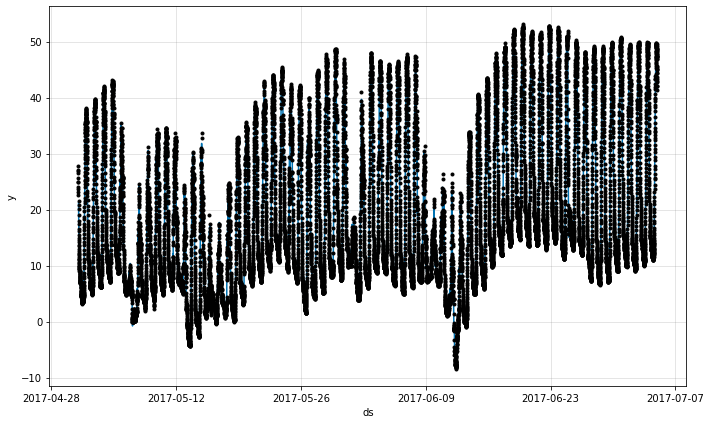

In [5]:
future = m.make_future_dataframe(df, n_historic_predictions=True)
forecast = m.predict(future)
fig = m.plot(forecast)

The predictions are now very precise, but this is not a big surprise, as we are just forecasting the very next 5 minutes.

When plotting the model parameters, the panel 'AR weight' displays the weight given to the 12 last observed values, these can be interpreted as our 'AR coefficients':

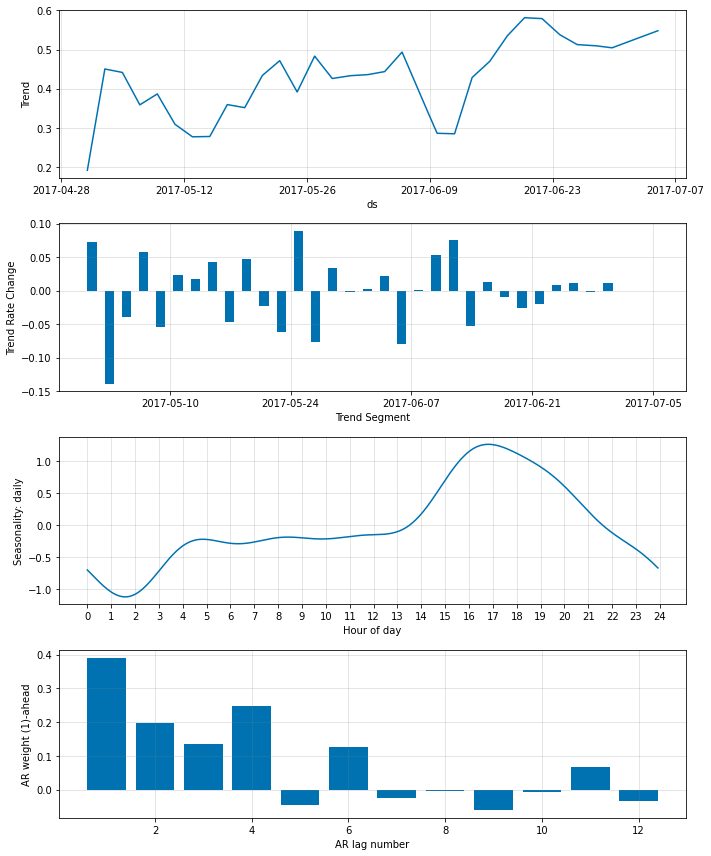

In [6]:
# fig_comp = m.plot_components(forecast)
m = m.highlight_nth_step_ahead_of_each_forecast(1) # temporary workaround to plot actual AR weights
fig_param = m.plot_parameters()

The 'AR weight' plot shows that the most recent observations are given significantly more weight compared to more distant observations.

## Multi-step forecast
To predict multiple steps into the future, we could 'unroll' our single-step model, by predicting a step ahead, adding the forecasted value to our data, and then forecasting the next step until we reach the horizon we are interested in. 
However, there is a better way to do this: We can directly forecast multiple steps ahead with NeuralProphet.

We can set `n_forecasts` to the desired number of steps we would like to forecast (also known as 'forecast horizon').
NeuralProphet will forecast `n_forecasts` steps into the future, at every single step. Thus, we have `n_forecasts` overlapping predictions of vaying age at every historic point. 

When icreasing the forecast horizon `n_forecasts`, we should also increase the number of past observations `n_lags` to at least the same value.

Here, we forecast the next 3 hours based on the last observed 6 hours, in 5-minute steps:


In [7]:
m = NeuralProphet(
    n_lags=6*12,
    n_forecasts=3*12,
    changepoints_range=0.95,
    n_changepoints=30,
    weekly_seasonality=False,
    log_level="INFO",
    train_speed=-1,
)
metrics = m.fit(df, freq='5min')

INFO: nprophet - _handle_missing_data: 12 NaN values in column y were auto-imputed.
INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 6
INFO: nprophet.config - apply_train_speed: train_speed--1 decreased batch_size to 64
INFO: nprophet.config - apply_train_speed: train_speed--1 increased epochs to 12


INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E-01
INFO: nprophet.config - apply_train_speed: train_speed--1 decreased learning_rate to 0.09369087114301929
Epoch[12/12]: 100%|██████████| 12/12 [00:09<00:00,  1.21it/s, SmoothL1Loss=0.000977, MAE=1.79, RegLoss=0]


INFO: nprophet - _handle_missing_data: 12 NaN values in column y were auto-imputed.


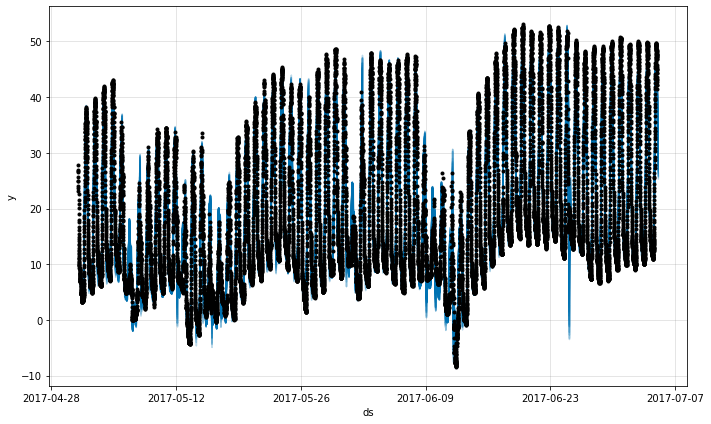

In [8]:
future = m.make_future_dataframe(df, n_historic_predictions=True)
forecast = m.predict(future)
fig = m.plot(forecast)

We see that our forecast sometimes miss-predicts for a day and then returns again to more accurate forecasts. Let's have a closer look at that over-prediction on day 6 of our data:

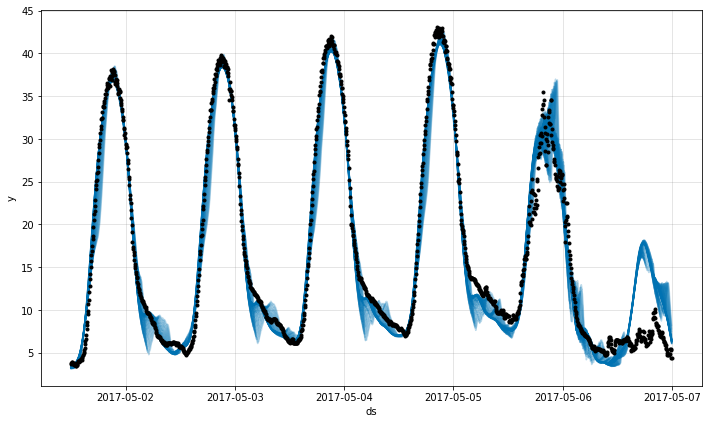

In [9]:
fig = m.plot(forecast[144:6*288])

On day 6, the redorded temperature drops at nighttime. Based on the observed lower nighttime temperatures, our model predicts a lower daytime peak. However, the actual daytime temperatures are anomalously low, barely higher than during the night. Thus, leading to an overprediction.

We can again visualize the relative importance of the lags:

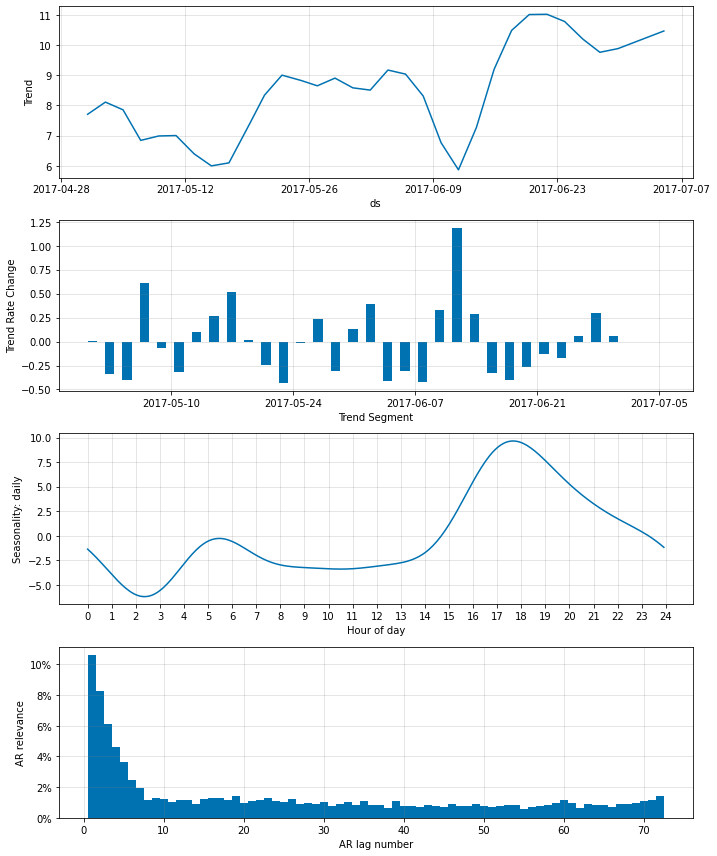

In [10]:
# fig_comp = m.plot_components(forecast)
fig_param = m.plot_parameters()

Note that the 'AR relevance' is the relative importance of a lag, averaged over all `n_forecasts`.

We can have a closer look at a particular forecast horizon by highlighting the n-th step ahead of each forecast. Here we focus on the temperature predicted 3 hours ahead

In [11]:
m = m.highlight_nth_step_ahead_of_each_forecast(3*12)

Let's replot the first 6 days and compare it to the forecast one-step-ahead

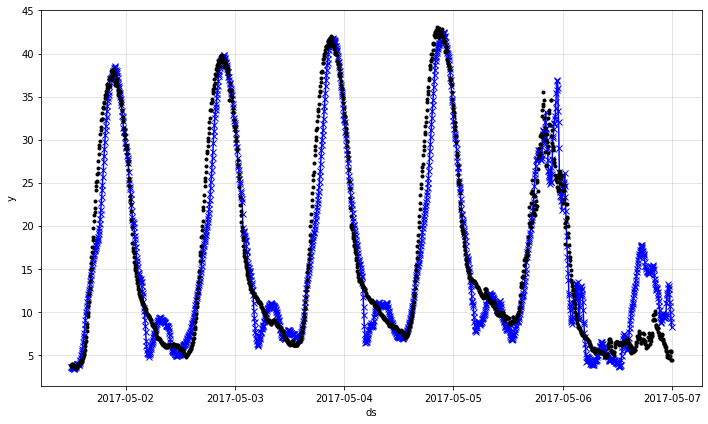

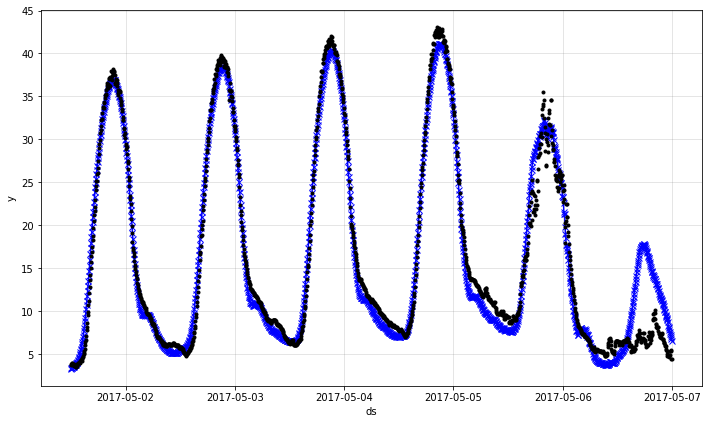

In [12]:
fig = m.plot(forecast[144:6*288])
m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig = m.plot(forecast[144:6*288])

We observe the single-step ahead forecast to be much more accurate compared to the 3 hour ahead forecast. However, neither is able to forecast the anomaly on day 6.

We can also have a closer look at the weights for the different 3 hour ahead forecast:

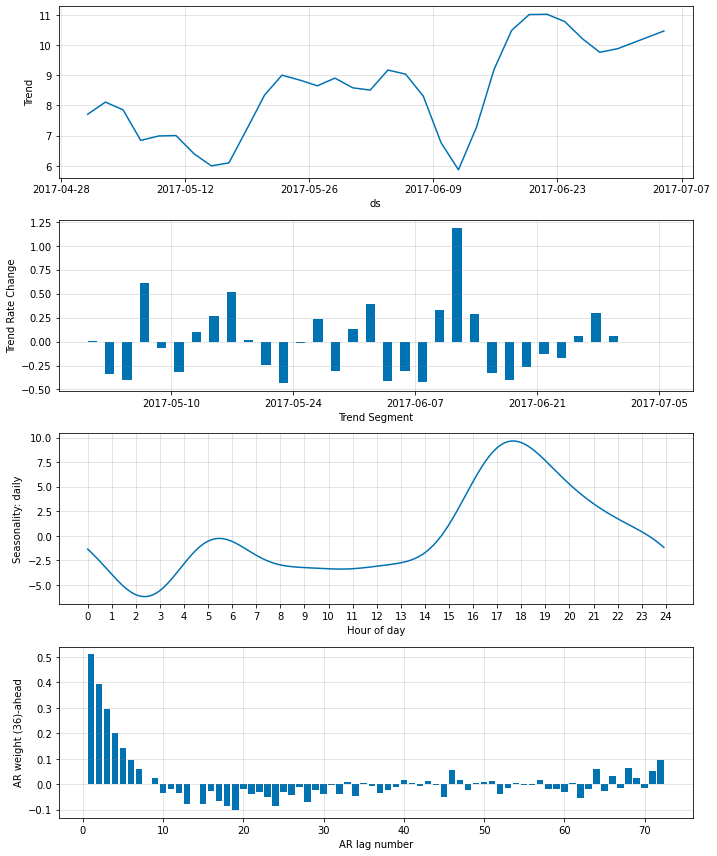

In [13]:
m = m.highlight_nth_step_ahead_of_each_forecast(3*12)
fig_param = m.plot_parameters()

The coefficients seem to be rather noisy. We can address this by inducint sparsity: